### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1jFewBP-6GBQ_mrl9PGpdk0vl_FFXQOBv'

fluff, id = link.split('=')

print (id) # Verify that you have everything after '='

1jFewBP-6GBQ_mrl9PGpdk0vl_FFXQOBv


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('FullIJCNN2013.zip')  
!unzip FullIJCNN2013.zip

Archive:  FullIJCNN2013.zip
replace FullIJCNN2013/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224) # original was (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))

    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        
        # preprocessing with histogram equalization
        # ref: Vision por Computador UPM Course
        # ref: https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
        # ref: https://stackoverflow.com/questions/31998428/opencv-python-equalizehist-colored-image
        
        #img_yuv = cv2.cvtColor(sign, cv2.COLOR_BGR2YUV)

        # equalize the histogram of the Y channel
        #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

        # convert the YUV image back to RGB format
        #sign = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        
        sign_resized = cv2.resize(sign, SIGN_SIZE)        
        
        # save results
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

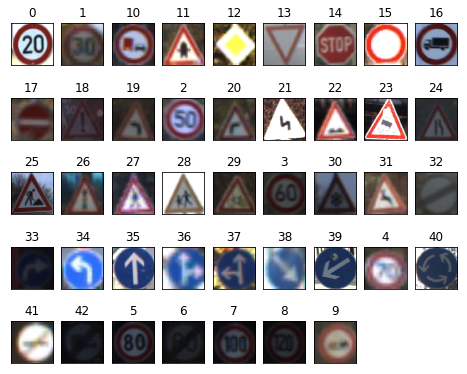

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
    #plt.imshow(train_signs[int(np.random.choice(indices, 1))])
plt.show()

In [4]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam, SGD

act = LeakyReLU(alpha=0.3)

cnn = Sequential()
# convolutional layers
cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale


cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

# dense layers
cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(Dropout(0.3))

cnn.add(Dense(256))
cnn.add(BatchNormalization())
cnn.add(Activation(act))

cnn.add(Dropout(0.3))

cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))

lr = 0.01
#opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_10 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_11 (Activation)   (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 32)        0         
__________

In [7]:
data = cnn.fit(tr_signs, tr_labels, batch_size=32, epochs=30, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Train on 600 samples, validate on 252 samples
Epoch 1/30
 - 5s - loss: 3.5797 - acc: 0.1617 - val_loss: 5.3004 - val_acc: 0.1508
Epoch 2/30
 - 1s - loss: 2.4344 - acc: 0.3450 - val_loss: 2.8360 - val_acc: 0.3016
Epoch 3/30
 - 1s - loss: 1.7786 - acc: 0.5033 - val_loss: 3.0942 - val_acc: 0.2063
Epoch 4/30
 - 1s - loss: 1.3408 - acc: 0.5950 - val_loss: 1.7834 - val_acc: 0.5119
Epoch 5/30
 - 2s - loss: 1.0950 - acc: 0.6800 - val_loss: 1.9715 - val_acc: 0.4444
Epoch 6/30
 - 2s - loss: 0.8602 - acc: 0.7450 - val_loss: 1.8289 - val_acc: 0.4722
Epoch 7/30
 - 2s - loss: 0.6076 - acc: 0.8400 - val_loss: 1.2243 - val_acc: 0.6667
Epoch 8/30
 - 2s - loss: 0.4514 - acc: 0.8933 - val_loss: 1.2541 - val_acc: 0.6786
Epoch 9/30
 - 1s - loss: 0.3317 - acc: 0.9367 - val_loss: 1.2848 - val_acc: 0.6310
Epoch 10/30
 - 2s - loss: 0.2784 - acc: 0.9417 - val_loss: 1.0369 - val_acc: 0.7302
Epoch 11/30
 - 1s - loss: 0.1755 - acc: 0.9717 - val_loss: 0.8899 - val_acc

In [8]:
start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

CNN took 0.3768482208251953 seconds
Test loss: 0.3178430259062643 - Accuracy: 0.9252077563977968


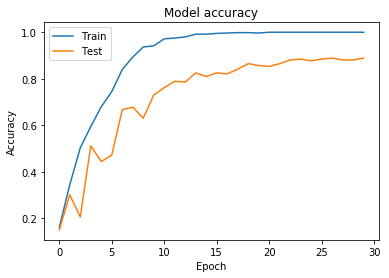

In [9]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

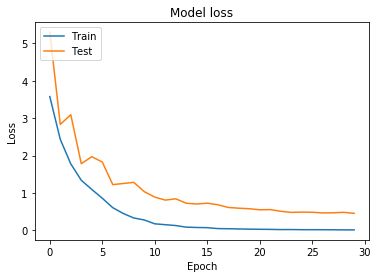

In [10]:
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

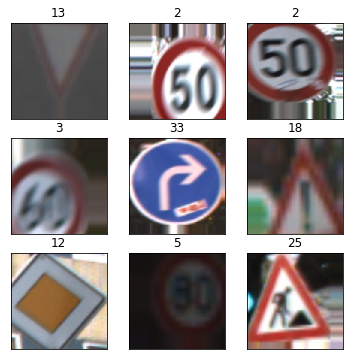

Epoch 1/60
 - 12s - loss: 3.4381 - acc: 0.1512 - val_loss: 3.8855 - val_acc: 0.1548
Epoch 2/60
 - 11s - loss: 2.7742 - acc: 0.2655 - val_loss: 3.1959 - val_acc: 0.2183
Epoch 3/60
 - 11s - loss: 2.4533 - acc: 0.3181 - val_loss: 2.5145 - val_acc: 0.3056
Epoch 4/60
 - 12s - loss: 2.1841 - acc: 0.3722 - val_loss: 2.2267 - val_acc: 0.3730
Epoch 5/60
 - 11s - loss: 1.9583 - acc: 0.4150 - val_loss: 2.1989 - val_acc: 0.3492
Epoch 6/60
 - 11s - loss: 1.7692 - acc: 0.4662 - val_loss: 2.1673 - val_acc: 0.3770
Epoch 7/60
 - 11s - loss: 1.6289 - acc: 0.4873 - val_loss: 1.9096 - val_acc: 0.4127
Epoch 8/60
 - 11s - loss: 1.4313 - acc: 0.5465 - val_loss: 1.8145 - val_acc: 0.4563
Epoch 9/60
 - 11s - loss: 1.3590 - acc: 0.5611 - val_loss: 1.5925 - val_acc: 0.5159
Epoch 10/60
 - 11s - loss: 1.2459 - acc: 0.5926 - val_loss: 1.6294 - val_acc: 0.5238
Epoch 11/60
 - 12s - loss: 1.0758 - acc: 0.6475 - val_loss: 1.5109 - val_acc: 0.5119
Epoch 12/60
 - 11s - loss: 1.0652 - acc: 0.6317 - val_loss: 1.4881 - val_a

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=32), epochs=60, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

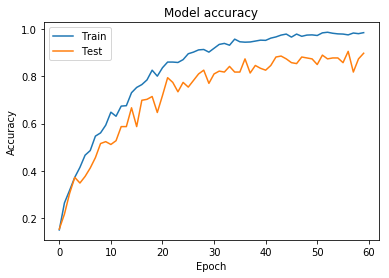

In [13]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

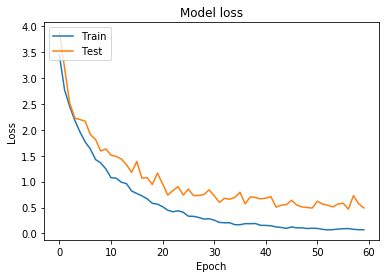

In [14]:
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()